# Visualize weights

In [1]:
import os
from nilearn.input_data import NiftiMasker
from nilearn import image

from nilearn.plotting import view_img, plot_stat_map
import nibabel as nb
import numpy as np
import pickle
import pandas as pd
from templateflow import api as tflow

# from nilearn.reporting import get_clusters_table
from nilearn.image import threshold_img
from mni_to_atlas import AtlasBrowser
import atlasreader

pd.set_option("display.max_rows", 100)

atlas = AtlasBrowser("AAL3")

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [2]:
data_root = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2"
func_clean_dir = os.path.join(data_root, "derivatives", "func_clean")
fmriprep_dir = os.path.join(data_root, "derivatives", "fmriprep23")
stab_mask_dir = os.path.join(data_root, "derivatives", "mvpa_08_stability_bold", "stab_full_masks")  # for stability masks
weights_dir = os.path.join(data_root, "derivatives", "mvpa_08_stability_bold", "weights")  # for weights

# check if weights folder exist, if not create it
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

In [3]:
# Load the data from the file
with open("results_mvpa_08.pkl", "rb") as file:
    data_loaded = pickle.load(file)

# Access the variables
weights_list = data_loaded["weights_list"]

In [4]:
subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
class_names = ["JoyfulActivation", "Nostalgia", "Peacefulness", "Power", "Sadness", "Tenderness", "Tension", "Transcendence", "Wonder"]

# Main iteration

In [5]:
for idx, sub in enumerate(subject_list):
    print(sub)

    # load the stability mask
    # stab_mask_data = np.load(os.path.join(stab_mask_dir, f"sub-{sub}_STAB.npy"))
    # example_func = nb.load(os.path.join(func_clean_dir, f"sub-{sub}_ses-01_task-02a_run-1_cleaned.nii.gz"))

    # stab_mask_img = nb.Nifti1Image(stab_mask_data, example_func.affine, example_func.header)

    # thres = 0.1
    # stab_mask_img_thres = image.threshold_img(stab_mask_img, threshold=thres, two_sided=False, copy_header=True)
    # stab_mask_img_thres_bin = image.binarize_img(stab_mask_img_thres)
    stab_mask_img_thres_bin = nb.load(os.path.join(stab_mask_dir, f"sub-{sub}_STAB_mask.nii.gz"))

    # load the weights
    sub_weights = weights_list[idx]

    # apply abs to the weights
    sub_weights = np.abs(sub_weights)

    # transform the weights to nifti image
    masker = NiftiMasker(mask_img=stab_mask_img_thres_bin, standardize=False, detrend=False)
    masker.fit()

    sub_weights_image = masker.inverse_transform(sub_weights)

    # iterate through the classes
    for i, class_name in enumerate(class_names):
        print(class_name)

        # save the weights image
        nb.save(sub_weights_image.slicer[..., i], os.path.join(weights_dir, f"sub-{sub}_weights_{class_name}.nii.gz"))


01
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
02
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
03
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
04
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
05
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
06
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
07
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
08
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
09
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
10
JoyfulActivation
Nostalgia
Peacefulness
Power
Sadness
Tenderness
Tension
Transcendence
Wonder
11
JoyfulActivation
Nostalgia


# Load weight images and sum per condition

In [6]:
# get all the weight images for all conditions

for curr_cond in class_names:
    print(curr_cond)

    weight_images = []
    for sub in subject_list:
        weight_images.append(nb.load(os.path.join(weights_dir, f"sub-{sub}_weights_{curr_cond}.nii.gz")))
    weight_images = image.concat_imgs(weight_images)

    # sum the images
    sum_weight_images = image.math_img("np.sum(imgs, axis=3)", imgs=weight_images)

    # apply spatial smooting
    sum_weight_images_smooth = image.smooth_img(sum_weight_images, fwhm=4)

    # apply threshold
    sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)

    # save the thresholded image
    sum_weight_images_smooth_thr.to_filename(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz")

    # get atlas data
    atlasreader.create_output(
        sum_weight_images_smooth_thr,
        cluster_extent=1,
        voxel_thresh=0,
        outdir="out_atlasreader",
        atlas=[
            "aal",
            "destrieux",
            "harvard_oxford",
            "juelich",
            "talairach_ba",
        ],  # all options: aal , aicha, desikan_killiany, destrieux, harvard_oxford, juelich , marsatlas, neuromorphometrics, talairach_ba, talairach_gyrus
        prob_thresh=25,  # minimum 25% probability for the label to be included
        export_figs=False,  # custom field
        outname=f"atlas_{curr_cond}",  # custom field
    )


JoyfulActivation


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Nostalgia


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Peacefulness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Power


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Sadness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Tenderness


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Tension


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Transcendence


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

Wonder


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2980806980.py:18: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_smooth_thr = threshold_img(sum_weight_images_smooth, threshold="99%", cluster_threshold=20)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarn

# Visualize per condition

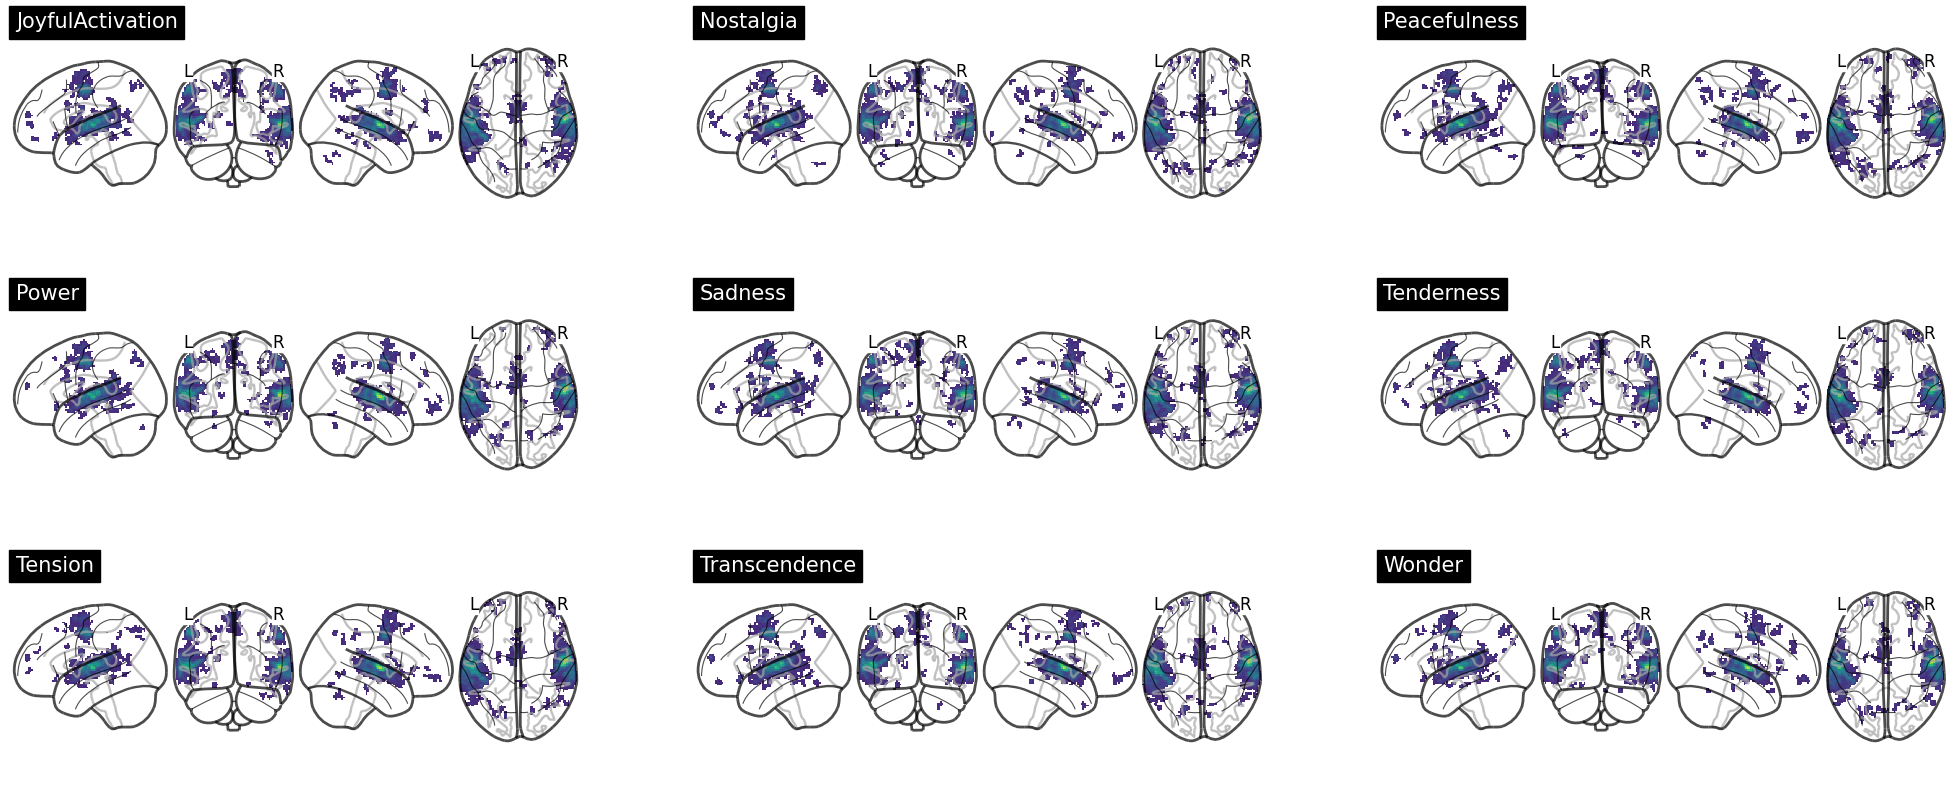

In [ ]:
# | label: mvpa_weights_per_condition_mosaic
# let's a subplot of the nine conditions
# in each subplot, a plot_glass_brain of the thresholded image

import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain

fig, axs = plt.subplots(3, 3, figsize=(25, 10))

for i, curr_cond in enumerate(class_names):
    # apply threshold
    sum_weight_images_smooth_thr = nb.load(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz")

    # plot the glass brain
    plot_glass_brain(
        sum_weight_images_smooth_thr,
        title=curr_cond,
        display_mode="lyrz",
        cmap="viridis",
        axes=axs.flatten()[i],
        vmax=0.05,
        resampling_interpolation="nearest",
    )

# Sum everything

/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2398723823.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  sum_weight_images_all_thr = threshold_img(sum_weight_images_all, threshold="99%", cluster_threshold=20)


Text(0, 0.5, 'Predictive Power (Sum of weights)')

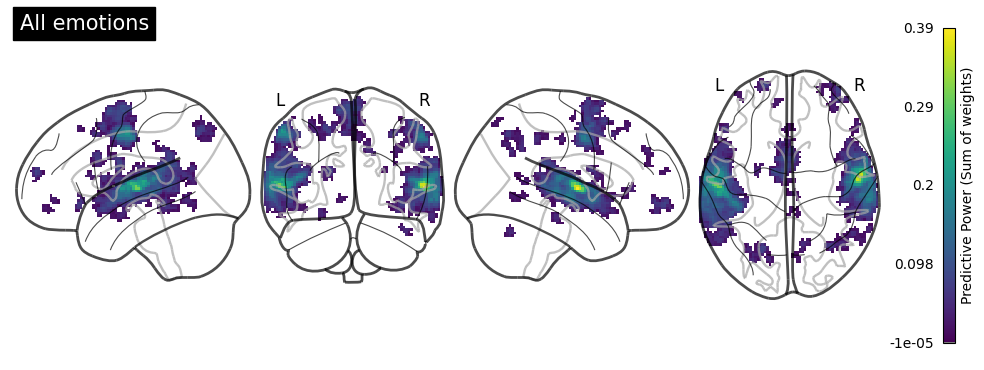

In [8]:
# let's sum the images of all conditions
weight_images = []
for curr_cond in class_names:
    weight_images.append(nb.load(f"out_weights_img/sum_weight_images_smooth_thr_{curr_cond}.nii.gz"))
weight_images = image.concat_imgs(weight_images)

# sum the images
sum_weight_images_all = image.math_img("np.sum(imgs, axis=3)", imgs=weight_images)

# threshold the sum image
sum_weight_images_all_thr = threshold_img(sum_weight_images_all, threshold="99%", cluster_threshold=20)

# plot
P = plot_glass_brain(
    sum_weight_images_all_thr,
    title="All emotions",
    display_mode="lyrz",
    cmap="viridis",
    # vmax=0.05,
    resampling_interpolation="nearest",
    colorbar=True,
)

# edit colorbar label
P._cbar.ax.set_ylabel("Predictive Power (Sum of weights)")

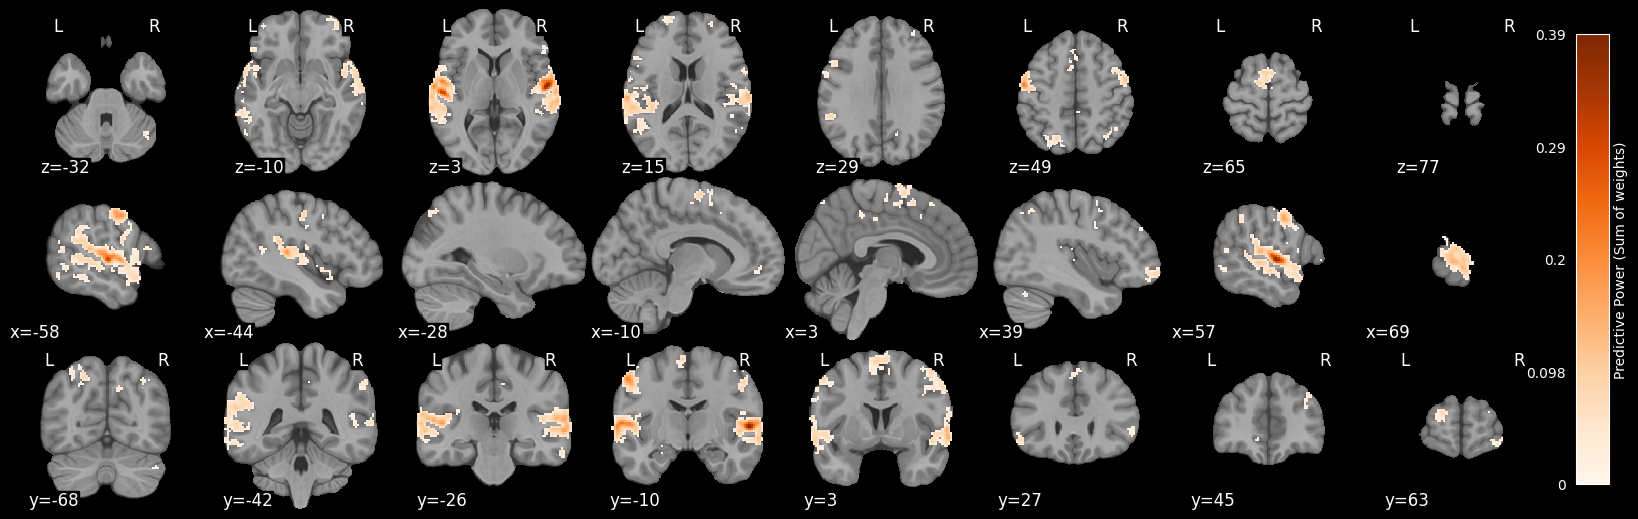

In [ ]:
# | label: mvpa_weights_mosaic

# beautiful mosaic figure

# Load the T1w image
t1w_img = tflow.get("MNI152NLin2009cAsym", desc="brain", resolution=1, suffix="T1w", extension="nii.gz")

# Create a new figure and axis with black background
fig = plt.figure(figsize=(16, 5), facecolor="black")

display = plot_stat_map(
    sum_weight_images_all_thr,
    threshold=0,
    display_mode="mosaic",
    cut_coords=8,
    colorbar=True,
    symmetric_cbar=False,
    cmap="Oranges",
    figure=fig,
    bg_img=t1w_img,
    resampling_interpolation="nearest",
)

# Customize the colorbar
cbar = display._cbar
cbar.set_label(f"Predictive Power (Sum of weights)")
# change colorbar label color to white
cbar.ax.yaxis.label.set_color("white")

# Show the plot
plt.show()

In [10]:
# get atlas data
atlasreader.create_output(
    sum_weight_images_all_thr,
    cluster_extent=1,
    voxel_thresh=0,
    outdir="out_atlasreader",
    atlas=[
        "aal",
        "destrieux",
        "harvard_oxford",
        "juelich",
        "talairach_ba",
    ],  # all options: aal , aicha, desikan_killiany, destrieux, harvard_oxford, juelich , marsatlas, neuromorphometrics, talairach_ba, talairach_gyrus
    prob_thresh=25,  # minimum 25% probability for the label to be included
    export_figs=False,  # custom field
    outname="atlas_ALL",  # custom field
)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)
/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/atlasreader/atlasreader.py:496: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresh_img = image.threshold_img(stat_img, threshold=voxel_thresh)


In [11]:
pd.read_csv("out_atlasreader/atlas_ALL_clusters.csv")

cluster_id  peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
0          1.0   -56.5   -16.5     3.5      0.065944    38096.0   
1          2.0    57.5   -10.5     3.5      0.073539    24456.0   
2          3.0   -10.5    -6.5    65.5      0.039414     6160.0   
3          4.0    55.5    -4.5    43.5      0.055509     4312.0   
4          5.0   -18.5   -66.5    47.5      0.029299     1648.0   
5          6.0    39.5    59.5    -8.5      0.030518     1256.0   
6          7.0    33.5   -66.5    47.5      0.027179     1176.0   
7          8.0   -48.5    13.5    27.5      0.030677      744.0   
8          9.0   -18.5    63.5    17.5      0.033143      664.0   
9         10.0   -64.5   -56.5    -6.5      0.023844      568.0   
10        11.0   -50.5    27.5    -8.5      0.035630      416.0   
11        12.0    37.5    45.5    33.5      0.019457      408.0   
12        13.0    11.5   -64.5    33.5      0.026763      400.0   
13        14.0    57.5   -60.5    -4.5      0.018488      384.0   
14        15.0    55.5    33.5     3.5      0.018984      352.0   
15        16.0    65.5   -52.5     9.5      0.017816      320.0   
16        17.0    59.5   -42.5    45.5      0.029111      320.0   
17        18.0   -24.5    -4.5   -18.5      0.026539      312.0   
18        19.0    63.5   -28.5   -18.5      0.027908      304.0   
19        20.0     3.5   -36.5    45.5      0.015681      272.0   
20        21.0    43.5   -64.5   -32.5      0.026786      272.0   
21        22.0     5.5   -22.5    43.5      0.019136      224.0   
22        23.0   -56.5    19.5    13.5      0.021890      224.0   
23        24.0     7.5   -76.5    55.5      0.015421      216.0   
24        25.0    -8.5    49.5    -6.5      0.019753      192.0   
25        26.0   -40.5    55.5   -12.5      0.017921      184.0   
26        27.0    25.5    61.5    17.5      0.016330      168.0   

                                                  aal  \
0                               28.85% Temporal_Sup_L   
1                               53.03% Temporal_Sup_R   
2   67.92% Supp_Motor_Area_L; 26.49% Supp_Motor_Ar...   
3         66.42% Precentral_R; 26.16% Frontal_Mid_2_R   
4                               90.78% Parietal_Sup_L   
5                              64.33% Frontal_Mid_2_R   
6             63.27% Angular_R; 34.69% Parietal_Inf_R   
7   52.69% Frontal_Inf_Tri_L; 38.71% Frontal_Inf_O...   
8                              93.98% Frontal_Sup_2_L   
9        47.89% Temporal_Mid_L; 43.66% Temporal_Inf_L   
10                         80.77% Frontal_Inf_Orb_2_L   
11                            100.00% Frontal_Mid_2_R   
12                                 90.00% Precuneus_R   
13       50.00% Temporal_Inf_R; 50.00% Temporal_Mid_R   
14                           90.91% Frontal_Inf_Tri_R   
15                              97.50% Temporal_Mid_R   
16      65.00% SupraMarginal_R; 30.00% Parietal_Inf_R   
17                                  79.49% Amygdala_L   
18                              86.84% Temporal_Inf_R   
19                             91.18% Cingulate_Mid_R   
20                          100.00% Cerebelum_Crus1_R   
21                             82.14% Cingulate_Mid_R   
22                           82.14% Frontal_Inf_Tri_L   
23                                100.00% Precuneus_R   
24                           95.83% Frontal_Med_Orb_L   
25            47.83% Frontal_Mid_2_L; 30.43% OFClat_L   
26                            100.00% Frontal_Sup_2_R   

                                            destrieux  \
0                                      47.40% Unknown   
1                                      45.34% Unknown   
2           38.44% Unknown; 35.32% ctx_lh_G_front_sup   
3          42.30% Unknown; 30.06% ctx_rh_G_precentral   
4                                      50.97% Unknown   
5             49.68% ctx_rh_G_orbital; 29.94% Unknown   
6   44.90% Right-Cerebral-White-Matter; 30.61% ctx...   
7   56.99% Unknown; 36.56% ctx_lh_G_front_inf-Oper...   
8        40.96% c

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/nilearn/image/image.py:1245: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img=threshold_img(


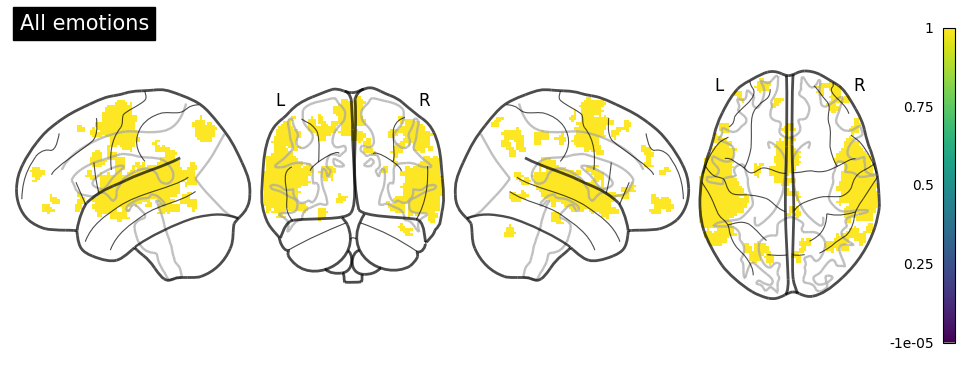

In [12]:
# create a binary mask based on sum_weight_images_all_thr
sum_weight_images_all_thr_bin = image.binarize_img(sum_weight_images_all_thr)

# plot mask
P = plot_glass_brain(
    sum_weight_images_all_thr_bin,
    title="All emotions",
    display_mode="lyrz",
    cmap="viridis",
    resampling_interpolation="nearest",
    colorbar=True,
)

# export
sum_weight_images_all_thr_bin.to_filename("out_weights_img/sum_weight_images_all_thr_bin.nii.gz")

# ANOVA

In [13]:
import templateflow.api as tf

t1w_gm_img = tf.get("MNI152NLin2009cAsym", label="GM", suffix="probseg", resolution=2, extension="nii.gz")
t1w_gm_img_mask = image.threshold_img(t1w_gm_img, threshold=0.15, copy_header=True)

In [14]:
# combine all images
weight_images_all = []
labels_all = []
for curr_cond in class_names:
    for sub in subject_list:
        # load
        curr_img = nb.load(os.path.join(weights_dir, f"sub-{sub}_weights_{curr_cond}.nii.gz"))
        # smoooth
        curr_img_smooth = image.smooth_img(curr_img, fwhm=4)
        # gm mask
        curr_img_smooth_masked = image.math_img("img * mask", img=curr_img_smooth, mask=t1w_gm_img_mask)
        # append
        weight_images_all.append(curr_img_smooth_masked)

        # labels
        labels_all.append(curr_cond)

weight_images_all = image.concat_imgs(weight_images_all)

print(weight_images.shape)
print(len(labels_all))

(97, 115, 97, 9)
180


In [15]:
# for each voxel, let's conduct an ANOVA with the label as the study variable
from scipy.stats import f_oneway, kruskal

# iterate on the voxels (97 x 115 x 97)
voxel_data = weight_images_all.get_fdata()

print(np.sum(abs(voxel_data) < 0.0001))

# set all values that are exactly 0 to NaN
voxel_data[abs(voxel_data) < 0.0001] = np.nan

# Convert labels_all to a NumPy array for indexing
labels_array = np.array(labels_all)

# intialize array to save ANOVA results
anova_results_f = np.zeros((voxel_data.shape[0], voxel_data.shape[1], voxel_data.shape[2]))
anova_results_p = np.zeros((voxel_data.shape[0], voxel_data.shape[1], voxel_data.shape[2]))

for xx in range(voxel_data.shape[0]):
    for yy in range(voxel_data.shape[1]):
        for zz in range(voxel_data.shape[2]):
            v_data = voxel_data[xx, yy, zz, :]

            # if v_data is all zeros or nan, move on
            if np.all(v_data == 0) or np.all(np.isnan(v_data)):
                continue
            else:
                print(xx, yy, zz)

                # Conduct the ANOVA
                stat_f, stat_p = kruskal(*[v_data[labels_array == label] for label in class_names], nan_policy="omit")

                anova_results_f[xx, yy, zz] = stat_f
                anova_results_p[xx, yy, zz] = stat_p


185142117
12 48 37
12 48 38
12 49 37
12 49 38
13 42 39
13 42 40
13 42 41
13 43 37
13 43 38
13 43 39
13 43 40
13 43 41
13 43 42
13 44 35
13 44 36
13 44 37
13 44 38
13 44 39
13 44 40
13 44 41
13 44 42
13 44 45
13 44 46
13 45 34
13 45 35
13 45 36
13 45 37
13 45 38
13 45 39
13 45 40
13 45 41
13 45 42
13 45 43
13 45 44
13 45 45
13 45 46
13 45 47
13 45 48
13 46 33
13 46 34
13 46 35
13 46 36
13 46 37
13 46 38
13 46 39
13 46 40
13 46 41
13 46 42
13 46 43
13 46 44
13 46 45
13 46 46
13 46 47
13 46 48
13 47 33
13 47 34
13 47 35
13 47 36
13 47 37
13 47 38
13 47 39
13 47 40
13 47 41
13 47 42
13 47 43
13 47 44
13 47 45
13 47 46
13 47 47
13 47 48
13 48 33
13 48 34
13 48 35
13 48 36
13 48 37
13 48 38
13 48 39
13 48 40
13 48 41
13 48 42
13 48 43
13 48 44
13 48 45
13 48 46
13 48 47
13 48 48
13 49 33
13 49 34
13 49 35
13 49 36
13 49 37
13 49 38
13 49 39
13 49 40
13 49 41
13 49 42
13 49 43
13 49 44
13 49 45
13 49 46
13 49 47
13 50 30
13 50 31
13 50 32
13 50 33
13 50 34
13 50 35
13 50 36
13 50 37
13 50 38


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_21254/2486769326.py:31: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_f, stat_p = kruskal(*[v_data[labels_array == label] for label in class_names], nan_policy="omit")


13 60 32
13 60 33
13 60 34
14 39 39
14 39 40
14 39 41
14 39 42
14 39 43
14 40 37
14 40 38
14 40 39
14 40 40
14 40 41
14 40 42
14 40 43
14 40 44
14 41 34
14 41 35
14 41 36
14 41 37
14 41 38
14 41 39
14 41 40
14 41 41
14 41 42
14 41 43
14 41 44
14 41 45
14 41 46
14 41 47
14 41 48
14 41 49
14 42 33
14 42 34
14 42 35
14 42 36
14 42 37
14 42 38
14 42 39
14 42 40
14 42 41
14 42 42
14 42 43
14 42 44
14 42 45
14 42 46
14 42 47
14 42 48
14 42 49
14 42 50
14 42 51
14 42 52
14 42 53
14 43 32
14 43 33
14 43 34
14 43 35
14 43 36
14 43 37
14 43 38
14 43 39
14 43 40
14 43 41
14 43 42
14 43 43
14 43 44
14 43 45
14 43 46
14 43 47
14 43 48
14 43 49
14 43 50
14 43 51
14 43 52
14 43 53
14 43 54
14 44 31
14 44 32
14 44 33
14 44 34
14 44 35
14 44 36
14 44 37
14 44 38
14 44 39
14 44 40
14 44 41
14 44 42
14 44 43
14 44 44
14 44 45
14 44 46
14 44 47
14 44 48
14 44 49
14 44 50
14 44 51
14 44 52
14 44 53
14 44 54
14 44 55
14 44 56
14 45 30
14 45 31
14 45 32
14 45 33
14 45 34
14 45 35
14 45 36
14 45 37
14 45 38
1

In [16]:
# unique values in anova_results_p excluding nans
unique_p_values = np.unique(anova_results_p[~np.isnan(anova_results_p)])
unique_p_values

array([0.00000000e+00, 7.12787265e-04, 9.55010114e-04, ...,
       9.99997588e-01, 9.99997793e-01, 9.99999334e-01])

827


/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



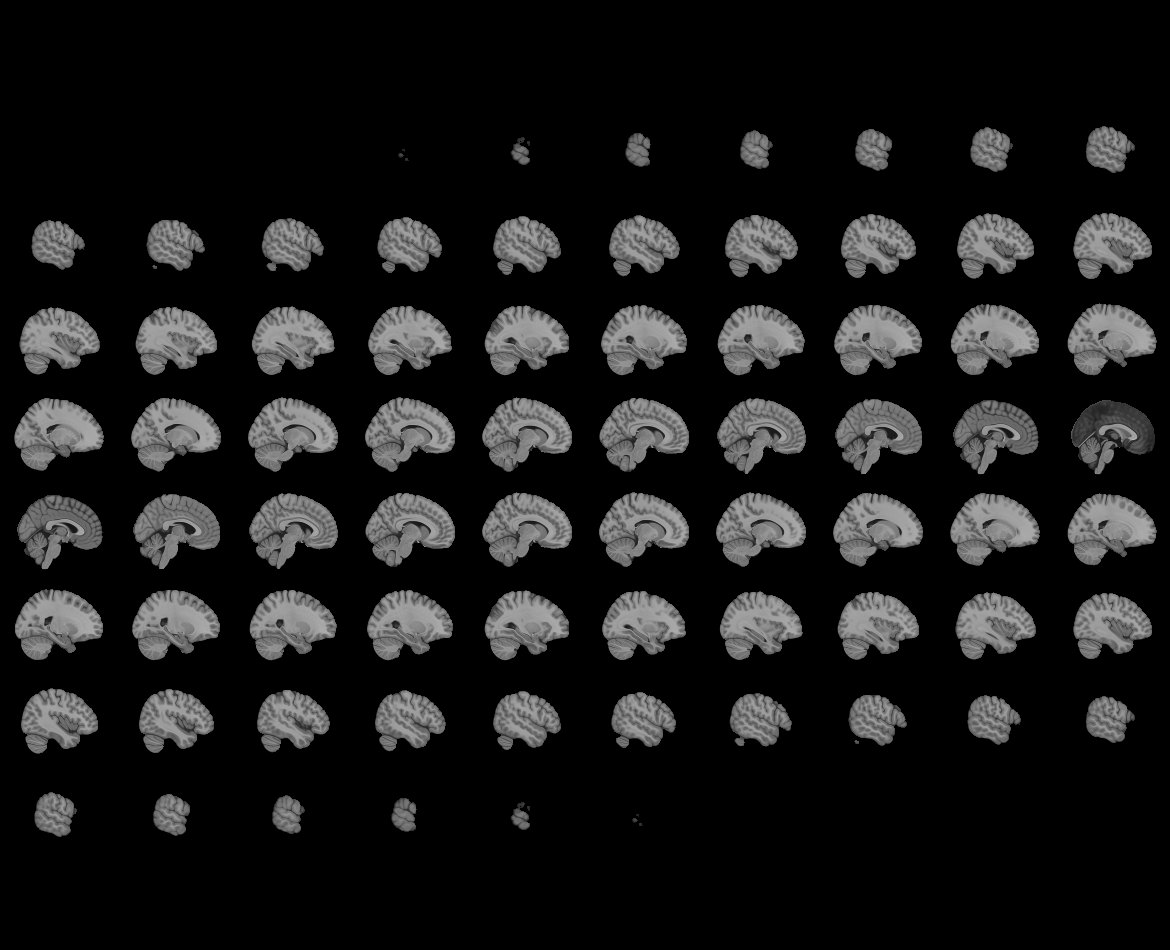
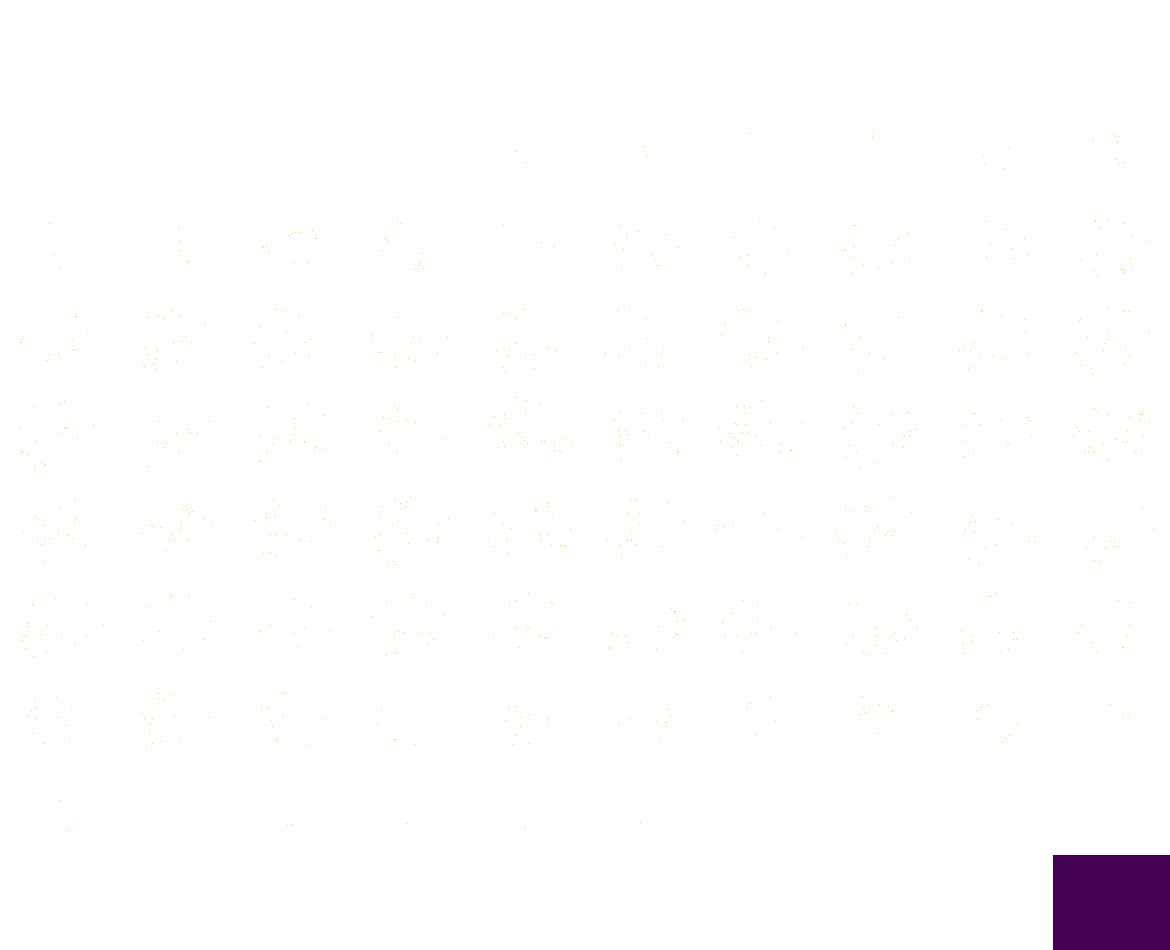

In [17]:
anova_results_sig = (anova_results_p < 0.05) & (anova_results_p != 0)
print(np.sum(anova_results_sig))

anova_results_sig_img = nb.Nifti1Image(anova_results_sig.astype(int), weight_images_all.affine, weight_images_all.header)

from nilearn.plotting import view_img

view_img(
    anova_results_sig_img, resampling_interpolation="nearest", colorbar=True, vmax=1, vmin=0, symmetric_cmap=False, cmap="viridis", width_view=1000
)